In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from glob import glob
from RaTag.scripts.wfm2read_fast import wfm2read # type: ignore
from RaTag.scripts.wfm_sca_trigger import moving_average # type: ignore
from RaTag.scripts.analyse_field_scans import *
from scipy.optimize import curve_fit

# Recommended rcParams for larger font sizes
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.titlesize'] = 18


In [60]:
def save_area_array(area_array, out_path):
    np.save(out_path, area_array)

# Define Gaussian function
def gaussian(x, amp, mean, sigma):
    return amp * np.exp(-(x - mean)**2 / (2 * sigma**2))

def fit_and_plot_gaussian(hist_data, bins, label=None, color=None, mask_range=(-4, 5)):
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    mask = (bin_centers > mask_range[0]) & (bin_centers < mask_range[1])
    popt, pcov = curve_fit(gaussian, bin_centers[mask], hist_data[mask], p0=[np.max(hist_data), np.mean(bin_centers[mask]), np.std(bin_centers[mask])])
    plt.bar(bins[:-1], hist_data, width=np.diff(bins), alpha=0.5, label=label, color=color)
    plt.plot(bin_centers, gaussian(bin_centers, *popt), 'r--', label=f'Gaussian fit {label}')
    plt.legend()
    return popt, pcov

def analyse_field_scan(base_dir, voltage_pairs, pattern = None, s2_cuts = (0.5e-5, 1.5e-5),
                       hist_cuts = (-5, 20)):
    # Drift field scan (vary both voltages together)
    if pattern is None:
        pattern = r'FieldScan_1GSsec_EL{}_Gate{}'
    glob_pattern = pattern + '\*.wfm'
    s2_lowcut, s2_upcut = s2_cuts
    hist_lowcut, hist_upcut = hist_cuts

    s2_areas = {}
    s2_areas_cuts = {}
    for el_v, gate_v in voltage_pairs:
        path = os.path.join(base_dir, glob_pattern.format(el_v, gate_v))
        files = sorted(glob(path))
        print(f'Integrating {len(files)} files for EL {el_v} V, Gate {gate_v} V')
        arr = extract_s2_areas(files, s2_lowcut, s2_upcut)
        s2_areas[(el_v, gate_v)] = arr
        s2_areas_cuts[(el_v, gate_v)] = apply_hist_cuts(arr, hist_lowcut, hist_upcut)
        # out_path = os.path.join(base_dir, f'FieldScan_EL{el_v}_Gate{gate_v}', f'histogram_EL{el_v}_Gate{gate_v}.png')
        # save_histogram(s2_areas_cuts[(el_v, gate_v)], bins=150, out_path=out_path,
        #                xlabel='S2 Area (mV*us)', ylabel='Counts',
        #                title=f'EL {el_v} V, Gate {gate_v} V')
        area_out_path = os.path.join(base_dir, pattern.format(el_v, gate_v), f'area_s2_EL{el_v}_Gate{gate_v}.npy')
        save_area_array(arr, area_out_path)

    # Plot all histograms together
    plt.figure(figsize=(8, 6))
    for (el_v, gate_v) in voltage_pairs:
        label = f"$E_{{drift}}$: {round(gate_v/1.4)} V/cm, $V_{{anode}}$: {el_v} V"
        plt.hist(s2_areas_cuts[(el_v, gate_v)], bins=150, alpha=0.5, label=label)
    plt.xlabel('S2 Area (mV*us)')
    plt.ylabel('Counts')
    plt.title('Drift field scan, EL field: 1.75 kV/cm')
    plt.legend()
    return s2_areas_cuts, s2_areas
    # plt.savefig(os.path.join(base_dir, 'field_scan_all.png'))
    


# Plot waveform and windows

In [3]:
trigger_file = r'E:\Pablos_Mighty_measurements\RUN1\FieldScans\sca_ttl.wfm'
trig = wfm2read(trigger_file, verbose=False)
trig_x, trig_y = trig[1], trig[0]
trig_y = trig_y / (10 * np.max(trig_y))

In [4]:
path = r'E:\Pablos_Mighty_measurements\RUN1\FieldScans\FieldScan_1GSsec_EL1450_Gate50'
files05 = glob(os.path.join(path, '*.wfm'))

c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


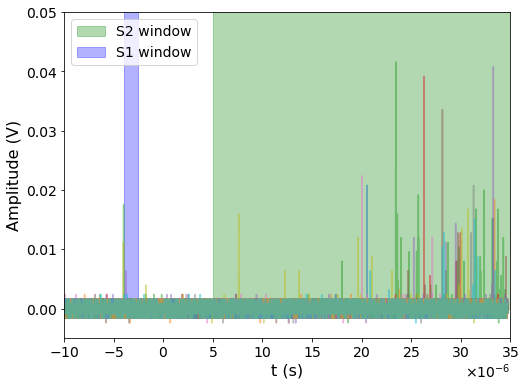

In [5]:
s2_lowcut, s2_upcut = 0.5e-5, 3.5e-5
s1_lowcut, s1_upcut = -0.4e-5, -0.25e-5
bs = -0.000772466
plt.figure(figsize=(8, 6))
for f in files05[:10]:
    wf = wfm2read(f)
    V, t = -wf[0], wf[1]
    V -= bs
    plt.plot(t, V, alpha=0.5)

# plt.plot(trig_x, trig_y, label='Trigger SCA', color='black')
plt.fill_betweenx([0, 0.1], x1=s2_lowcut, x2=s2_upcut,
        color='green', alpha=0.3, label='S2 window')

plt.fill_betweenx([0, 0.1], x1=s1_lowcut, x2=s1_upcut,
        color='blue', alpha=0.3, label='S1 window')

plt.gca().set(xlim=(-1e-5, 3.5e-5), ylim=(-0.005, 0.05), xlabel='t (s)', ylabel='Amplitude (V)')
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(-6, -6))

# Baseline subtraction

In [13]:
pathbs = r'E:\Pablos_Mighty_measurements\RUN1\FieldScans\NoField\*.wfm'
filsbs = sorted(glob(pathbs))

c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


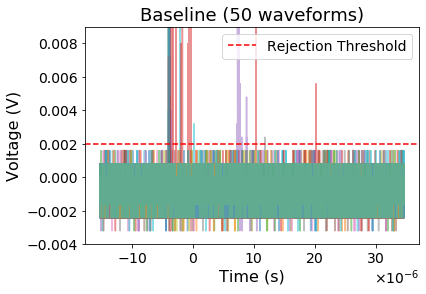

In [24]:
for f in filsbs[50:100]:
    wf = wfm2read(f)
    V, t = -wf[0], wf[1]
    plt.plot(t, V, alpha=0.5)
plt.axhline(0.002, color='r', linestyle='--', label='Rejection Threshold')
plt.legend()
ax = plt.gca()
ax.set(ylim=(-0.004, 0.009), xlabel='Time (s)', ylabel='Voltage (V)', title='Baseline (50 waveforms)')
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(-6, -6))

c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


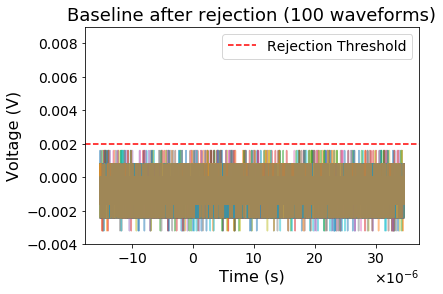

In [38]:
for f in filsbs[:100]:
    wf = wfm2read(f)
    V, t = -wf[0], wf[1]
    mask = V > 0.002
    if mask.any():
        continue
    plt.plot(t, V, alpha=0.5)
plt.axhline(0.002, color='r', linestyle='--', label='Rejection Threshold')
plt.legend()
ax = plt.gca()
ax.set(ylim=(-0.004, 0.009), xlabel='Time (s)', ylabel='Voltage (V)', title='Baseline after rejection (100 waveforms)')
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(-6, -6))

In [34]:
# Load all waveforms in one step
waveforms = np.array([ -wfm2read(f)[0] for f in filsbs ])

# Apply rejection: keep only waveforms where all V <= 0.002
mask = np.all(waveforms <= 0.002, axis=1)
avg_wf = waveforms[mask]

# Compute mean waveform
mean_wf = np.mean(avg_wf, axis=0)
len(avg_wf)

1086

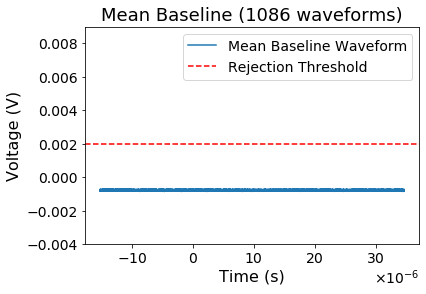

In [ ]:
plt.plot(t, mean_wf, label='Mean Baseline Waveform')
plt.axhline(0.002, color='r', linestyle='--', label='Rejection Threshold')
plt.legend()
ax = plt.gca()
ax.set(ylim=(-0.004, 0.009), xlabel='Time (s)', ylabel='Voltage (V)', title='Mean Baseline ({} waveforms)'.format(len(avg_wf)))
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(-6, -6))

In [37]:
pedestal = np.mean(mean_wf)
pedestal

-0.0007724662885404431

# Field scan, low range

In [35]:
import re
voltage_pairs_sat = []
subdirs = os.listdir(r'E:\Pablos_Mighty_measurements\RUN1\FieldScans_sat')
for subdir in subdirs:
    try:
        gate_voltage = int(re.search(r'Gate(\d+)', subdir).group(1))
        anode_voltage = int(re.search(r'EL(\d+)', subdir).group(1))
        print(f"Anode voltage : {anode_voltage}, Gate voltage : {gate_voltage}")
        voltage_pairs_sat.append((anode_voltage, gate_voltage))
    except AttributeError:
        continue

Anode voltage : 2100, Gate voltage : 700
Anode voltage : 2600, Gate voltage : 1200
Anode voltage : 3600, Gate voltage : 2200
Anode voltage : 4100, Gate voltage : 2700
Anode voltage : 2600, Gate voltage : 1200
Anode voltage : 3100, Gate voltage : 1700


Integrating 3000 files for EL 2100 V, Gate 700 V
Integrating 3000 files for EL 2600 V, Gate 1200 V
Integrating 3000 files for EL 3600 V, Gate 2200 V
Integrating 3000 files for EL 4100 V, Gate 2700 V
Integrating 3000 files for EL 2600 V, Gate 1200 V
Integrating 3000 files for EL 3100 V, Gate 1700 V


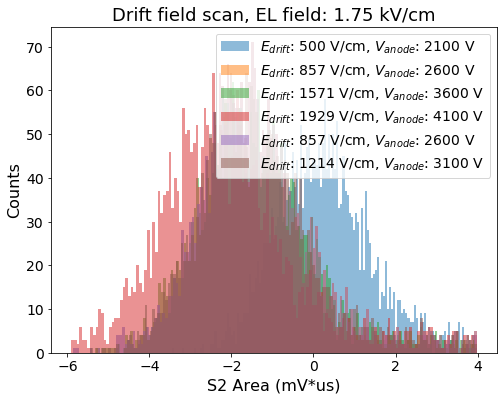

In [55]:
base_dir_sat = r'E:\Pablos_Mighty_measurements\RUN1\FieldScans_sat'
pattern = r'FieldScan_1GSsec_EL{}_Gate{}'
s2_lowcut, s2_upcut = 0.5e-5, 3.5e-5
hist_lowcut, hist_upcut = -6, 4

as2_cuts_sat, _ = analyse_field_scan(base_dir_sat, voltage_pairs_sat, pattern,
                                  s2_cuts=(s2_lowcut, s2_upcut), hist_cuts=(hist_lowcut, hist_upcut))

Integrating 3000 files for EL 2100 V, Gate 700 V
Integrating 3000 files for EL 2050 V, Gate 650 V
Integrating 3000 files for EL 2000 V, Gate 600 V
Integrating 3000 files for EL 1950 V, Gate 550 V


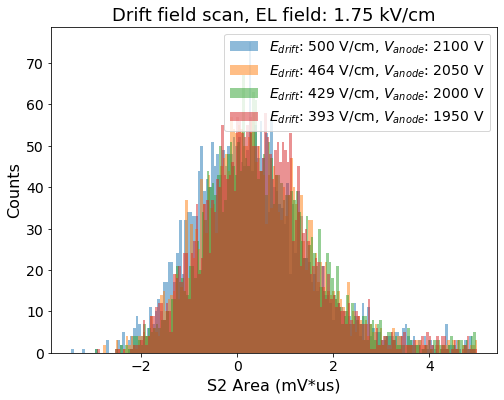

In [56]:
base_dir = r'E:\Pablos_Mighty_measurements\RUN1\FieldScans'
pattern = r'FieldScan_1GSsec_EL{}_Gate{}'
s2_lowcut, s2_upcut = 0.5e-5, 3.5e-5
hist_lowcut, hist_upcut = -4, 5
# voltage_pairs_hi = [(2200, 800), (2150,750), (2100, 700), (2050, 650), (2000, 600), (1950, 550)]

voltage_pairs_hi = [(2100, 700), (2050, 650), (2000, 600), (1950, 550)]
as2_cuts_hi, _ = analyse_field_scan(base_dir, voltage_pairs_hi, pattern,
                                  s2_cuts=(s2_lowcut, s2_upcut), hist_cuts=(hist_lowcut, hist_upcut))

Integrating 3000 files for EL 1850 V, Gate 450 V
Integrating 3000 files for EL 1750 V, Gate 350 V
Integrating 3000 files for EL 1650 V, Gate 250 V
Integrating 3000 files for EL 1550 V, Gate 150 V
Integrating 3000 files for EL 1500 V, Gate 100 V
Integrating 3000 files for EL 1475 V, Gate 75 V


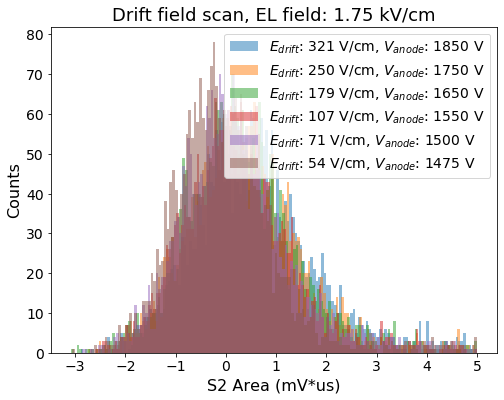

In [57]:
voltage_pairs_mid = [(1850, 450), (1750, 350), (1650, 250), (1550, 150), (1500, 100), (1475, 75)]
as2_cuts_mid, _ = analyse_field_scan(base_dir, voltage_pairs_mid, pattern,
                                  s2_cuts=(s2_lowcut, s2_upcut), hist_cuts=(hist_lowcut, hist_upcut))

Integrating 3000 files for EL 1470 V, Gate 70 V
Integrating 3324 files for EL 1465 V, Gate 65 V
Integrating 3000 files for EL 1460 V, Gate 60 V
Integrating 3000 files for EL 1450 V, Gate 50 V


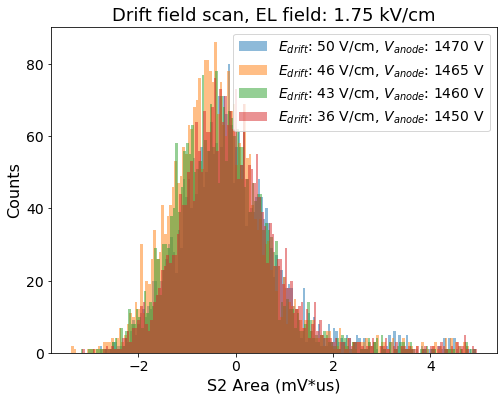

In [58]:
voltage_pairs_lo = [(1470, 70), (1465, 65), (1460, 60), (1450, 50)]
as2_cuts_lo, _ = analyse_field_scan(base_dir, voltage_pairs_lo, pattern,
                                  s2_cuts=(s2_lowcut, s2_upcut), hist_cuts=(hist_lowcut, hist_upcut))

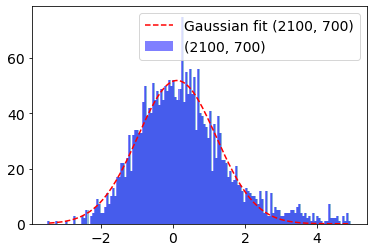

(2100, 700): amplitude=51.91, mean=0.12, sigma=1.09)


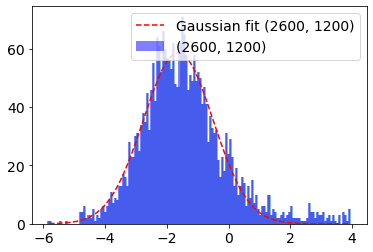

(2600, 1200): amplitude=58.65, mean=-1.63, sigma=1.13)


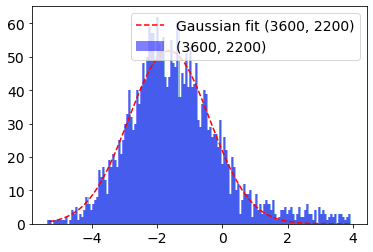

(3600, 2200): amplitude=51.77, mean=-1.63, sigma=1.24)


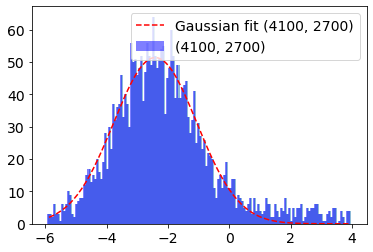

(4100, 2700): amplitude=51.37, mean=-2.41, sigma=1.36)


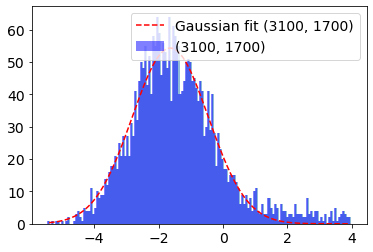

(3100, 1700): amplitude=54.32, mean=-1.64, sigma=1.18)


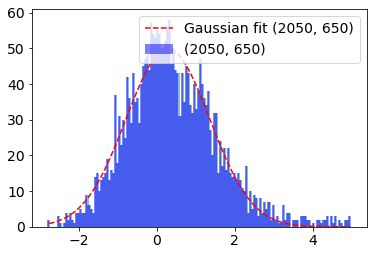

(2050, 650): amplitude=49.71, mean=0.28, sigma=1.08)


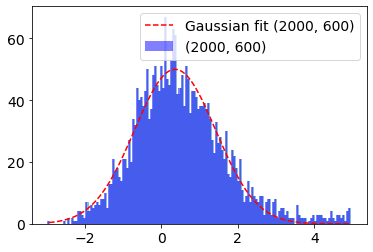

(2000, 600): amplitude=49.98, mean=0.36, sigma=1.06)


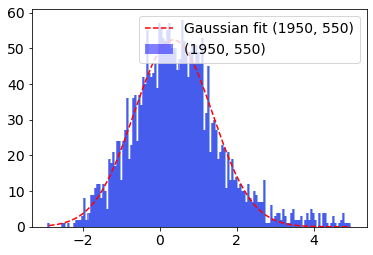

(1950, 550): amplitude=52.36, mean=0.35, sigma=1.02)


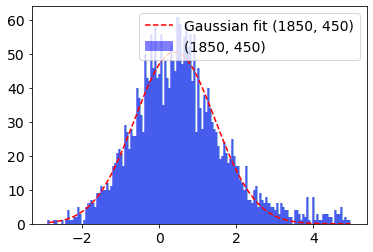

(1850, 450): amplitude=50.64, mean=0.40, sigma=1.05)


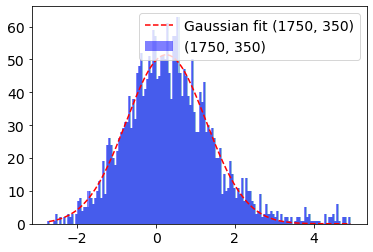

(1750, 350): amplitude=51.42, mean=0.26, sigma=1.01)


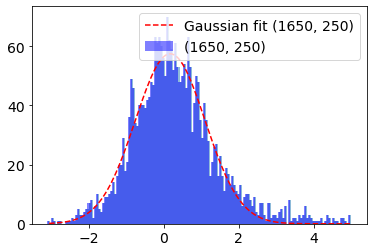

(1650, 250): amplitude=57.48, mean=0.17, sigma=0.93)


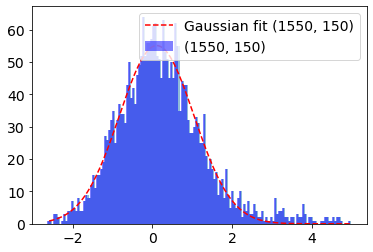

(1550, 150): amplitude=55.08, mean=0.11, sigma=0.94)


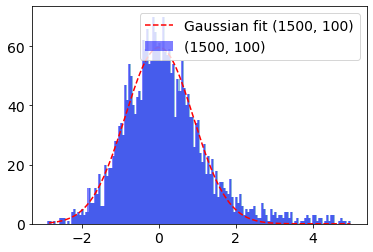

(1500, 100): amplitude=59.63, mean=0.01, sigma=0.88)


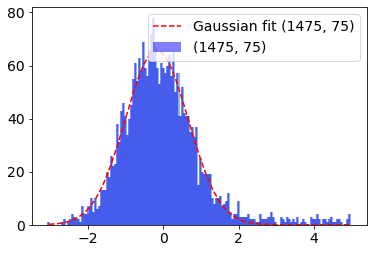

(1475, 75): amplitude=65.69, mean=-0.17, sigma=0.83)


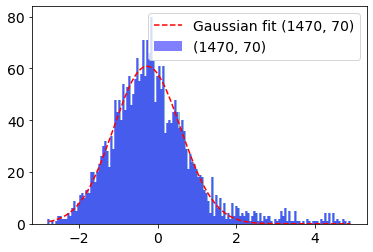

(1470, 70): amplitude=60.87, mean=-0.27, sigma=0.86)


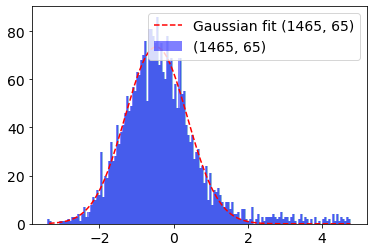

(1465, 65): amplitude=73.45, mean=-0.47, sigma=0.84)


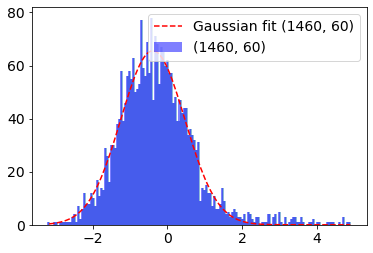

(1460, 60): amplitude=65.53, mean=-0.39, sigma=0.86)


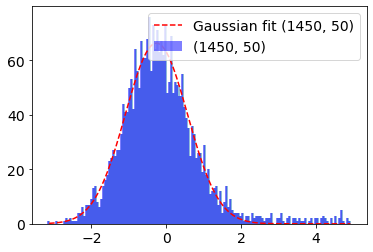

(1450, 50): amplitude=66.31, mean=-0.26, sigma=0.83)


In [62]:
as2_cuts = {**as2_cuts_sat, **as2_cuts_hi, **as2_cuts_mid, **as2_cuts_lo}

# as2_cuts = {**as2_cuts_hi, **as2_cuts_mid, **as2_cuts_lo}
# as2_cuts = {**as2_cuts_mid, **as2_cuts_lo}

# Loop over all histograms in as2_cuts and fit/plot
fit_results = {}
for key, a1 in as2_cuts.items():
    n, bins, _ = plt.hist(a1, bins=150, alpha=0.5)
    
    popt, pcov = fit_and_plot_gaussian(n, bins, label=str(key), color='blue')
    # plt.clf()
    plt.show()

    fit_results[key] = (popt, pcov)
    print(f'{key}: amplitude={popt[0]:.2f}, mean={popt[1]:.2f}, sigma={popt[2]:.2f})')

[(-0.7, 0.7),
 Text(0, 0.5, 'Mean S2 Area (mV$\\cdot$us)'),
 (0, 550),
 Text(0.5, 0, '$E_{drift}$ (V/cm)'),
 Text(0.5, 1.0, 'Mean S2 Area vs $E_{drift}$ (95% CI)')]

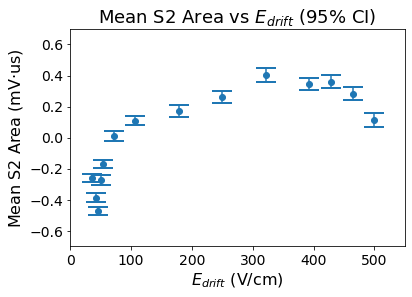

In [71]:
mean_gaussian = []
ci95_gaussian = []
rms_gaussian = []
for popt, pcov in fit_results.values():
    mean = popt[1]
    rms = popt[2]
    std_error = np.sqrt(pcov[1, 1])
    ci95 = 1.96 * std_error
    mean_gaussian.append(mean)
    ci95_gaussian.append(ci95)
    rms_gaussian.append(rms)

E_gate = [f[1]/1.4 for f in fit_results.keys()]
plt.errorbar(E_gate, mean_gaussian, yerr=ci95_gaussian, fmt='o', capsize=10, capthick=2)
# plt.errorbar(E_gate, mean_gaussian, yerr=rms_gaussian, fmt='o', capsize=10, capthick=2)

plt.gca().set(xlabel='$E_{drift}$ (V/cm)', ylabel='Mean S2 Area (mV$\cdot$us)', 
              title='Mean S2 Area vs $E_{drift}$ (95% CI)', 
              xlim=(0, 550), ylim=(-0.7, 0.7))

In [32]:
path_result = r'E:\Pablos_Mighty_measurements\RUN1\FieldScans\s2_area_ci95.csv'
df = pd.DataFrame({'E_gate': E_gate, 'mean_gaussian': mean_gaussian, 'ci95_gaussian': ci95_gaussian})
df.to_csv(path_result, index=False)